In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Tensorflow version: ",tf.__version__)

1 Physical GPUs, 1 Logical GPUs
Num GPUs Available:  1
Tensorflow version:  2.1.0


In [2]:
import os,shutil

# some parameters to set
# defaults should be ok for many situations

# if interative == 1 some plots of the train/validation accuraccies will be given
interactive = 1

# images get resized to these dimensions on import
dx=128 # you may want to consider the aspect ratio here,
dy=128 # and how much detail might be lost by scaling down
# also the "natural" size for the VGG16 net used here is 224x224

# source directory should have the source images in organised into subdirectories, one per image class
# e.g.   source_dir had subdirectories named: rabbits, currawongs, curlews, each of which has images of
# rabbits, currawongs and curlews in.
source_dir = './CellSourceImages'

# where the train/valid/test sets will be created
base_dir = "./CellTrainTestSplit"

# create (1) a train/valid/test split, or use previous split (0). Will delete old split if there is one there
new_datasplit = 1

# percentage of images to use in training, validation and testing. Should add up to 100!
train_split = 80 
valid_split = 10
test_split = 10

# training set and validation batch sizes
train_batch_size = 20
valid_batch_size = 50

# number of epochs to train for
num_epochs = 50

# If you have a set of images in a directory that you want to predict on after a classifier has been created,
# set the directory path here. Or set to '' if none.
#predictdir = '' 
predictdir = os.path.join(base_dir, 'test')


# with (1) or without (0) data augementation
# i.e. apply shears/zooms/rotations etc to expand training set
data_aug = 1

# whether (1) or not (0) to fine tune the pre-trained VGG16 network which is being used here for transfer learning
fine_tune = 1

# where to put the log files that can be read by tensorboard
log_dir = 'tensor_logs_test'

# size to resize input image to
target_size = (dx,dy) 

# name of the file to save model to once trained
model_name = 'model_trained.h5';

# if overfitting, the number of nodes in last dense layer (default num_dense = 256) could be reduced. 
#     Or increase training set size
num_dense = 24

# Other parameters you might like to optimise if it doesn't learn so well:
# - The learning rate below in 
#      optimizers.RMSprop(lr=1e-5)

In [3]:
# Organise images in directory with one subdirectory per image class
# into a new directory with train/validation/test sets in the new directory 

import numpy as np
from random import shuffle

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

dirs = os.listdir(source_dir)

print("Found datasets: ")
print(dirs)

nclasses = len(dirs)
print('Number of image classes is '+str(nclasses))

Found datasets: 
['PM', 'lysosome', 'mitochondria', 'peroxisome', 'cytoskeleton', 'ER', 'nucleus', 'golgi']
Number of image classes is 8


In [4]:
# split/recreate the dataset train/valid/test split
# note, it will overright previous data splits 

if new_datasplit == 1:
    print("Creating new train/valid/test data split in directory:")
    print(base_dir)
    if os.path.isdir(base_dir): 
        shutil.rmtree(base_dir) # delete any old train/valid/test splits

    os.mkdir(base_dir)
    os.mkdir(train_dir)
    os.mkdir(valid_dir)
    os.mkdir(test_dir)

    for dir in dirs:

        dir_train = os.path.join(train_dir,dir)
        dir_test = os.path.join(test_dir,dir)
        dir_valid = os.path.join(valid_dir,dir)

        os.mkdir(dir_train)
        os.mkdir(dir_test)
        os.mkdir(dir_valid)

        src_images = os.listdir(os.path.join(source_dir,dir))
        shuffle(src_images)
    
        nimages = len(src_images)
        train_list = src_images[0:int(nimages*train_split/100)]
        valid_list = src_images[int(nimages*train_split/100):int(nimages*(train_split+valid_split)/100)]
        test_list = src_images[int(nimages*(train_split+valid_split)/100):]
    
        for fname in train_list:
            src = os.path.join(source_dir, dir, fname)
            dst = os.path.join(base_dir, 'train', dir, fname)
            shutil.copyfile(src, dst)

        for fname in valid_list:
            src = os.path.join(source_dir, dir, fname)
            dst = os.path.join(base_dir, 'valid', dir, fname)
            shutil.copyfile(src, dst)
        
        for fname in test_list:
            src = os.path.join(source_dir, dir, fname)
            dst = os.path.join(base_dir, 'test', dir, fname)
            shutil.copyfile(src, dst)
else:
    print("Using train/valid/test data split from directory:")
    print(base_dir)    

Using train/valid/test data split from directory:
./CellTrainTestSplit


In [5]:
# Use the VGG16 pretrained CNN as a starting point which will later be fine tuned if fine_tune=1 is set.

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
    include_top=False,
    input_shape=(dx,dy,3)) 
# note: input_shape is optional as VGG16 can have arbitrary input shapes
# but scaling down is probable better computationally in most cases
# the "natural" image size of vgg16 is 224x224, FWIW


from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(num_dense, activation='relu')) # try reducing this number (256) if overfitting
model.add(layers.Dense(nclasses, activation='softmax')) 

In [6]:
model.summary()

# to see the VGG16 structure:
conv_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                196632    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 200       
Total params: 14,911,520
Trainable params: 14,911,520
Non-trainable params: 0
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_____________________________

In [7]:
# select without or with data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

if data_aug == 0:
    print("Not using data augmentation.")
    train_datagen = ImageDataGenerator(rescale=1./255)
else:
    # with data aug
    print("Using data augmentation.")
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        #rotation_range=40,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

Using data augmentation.


In [8]:
print("Training dataset:")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=train_batch_size,
    shuffle=True,
    class_mode='categorical')

Training dataset:
Found 667 images belonging to 8 classes.


In [9]:
print("Validation dataset:")

valid_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=valid_batch_size,
    class_mode='categorical')

Validation dataset:
Found 84 images belonging to 8 classes.


In [10]:
# now set up fine tuning tune
if fine_tune == 1:
    print("Will fine tune the VGG16 model.")
    conv_base.trainable = True
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
else:
    print("Will not fine tune the VGG16 model.")
    conv_base.trainable = False
    

Will fine tune the VGG16 model.


In [11]:
model.compile(loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])

In [12]:
# set up some stuff for tensorboard
import tensorflow.keras
callbacks = [
    tensorflow.keras.callbacks.TensorBoard(
    log_dir=log_dir, 
    )
]
# later run tensorboard on command line with :
# tensorboard --logdir='tensor_logs'
# where tensor_logs is the directory chosen for the log files

In [13]:
# we need some image libraries

from IPython.display import display, Image
import sys
from PIL import Image
sys.modules['Image'] = Image 
from PIL import Image
print(Image.__file__)
import Image
print(Image.__file__)

/home/nick/anaconda3/envs/tf2/lib/python3.6/site-packages/PIL/Image.py
/home/nick/anaconda3/envs/tf2/lib/python3.6/site-packages/PIL/Image.py


In [14]:
# train the model. The main parameter here is epochs which determines how many iterations to train for
# 

history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=1,
    callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 1 steps
Epoch 1/50
10/10 [==============================] - 7s 742ms/step - loss: 2.0139 - acc: 0.1900 - val_loss: 1.8605 - val_acc: 0.3600
Epoch 2/50
10/10 [==============================] - 1s 119ms/step - loss: 1.6947 - acc: 0.4800 - val_loss: 1.6249 - val_acc: 0.6200
Epoch 3/50
10/10 [==============================] - 3s 261ms/step - loss: 1.4778 - acc: 0.6203 - val_loss: 1.4251 - val_acc: 0.6600
Epoch 4/50
10/10 [==============================] - 1s 114ms/step - loss: 1.2459 - acc: 0.6631 - val_loss: 1.2484 - val_acc: 0.7000
Epoch 5/50
10/10 [==============================] - 1s 121ms/step - loss: 1.0703 - acc: 0.7150 - val_loss: 1.1206 - val_acc: 0.6800
Epoch 6/50
10/10 [==============================] - 1s 119ms/step - loss: 1.0296 - acc: 0.7000 - val_loss: 1.0257 - val_acc: 0.7200
Epoch 7/50
10/10 [=======================

In [15]:
# save the model
model.save(model_name)

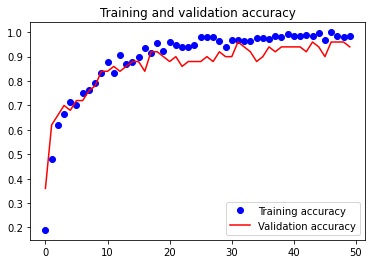

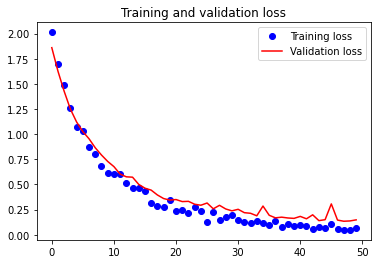

In [16]:
# plot the train / validation accuracy and losses if we're in interactive mode

if interactive == 1:
    import matplotlib.pyplot as plt
    %matplotlib inline  

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [18]:

# load a model to do testing with
from tensorflow.keras.models import load_model
model = load_model(model_name)

In [20]:
# test on 100 images of the test set
# set batch_size to the number of images in the test set if you want to test them all

from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

# where to get the images from
tdir=test_dir

test_generator = test_datagen.flow_from_directory(
    tdir,
    target_size=target_size,
    batch_size=100,
    class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=1)
print('Test set accuracy:', test_acc)

Found 86 images belonging to 8 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
Test set accuracy: 0.9767442


In [22]:
# do a misclassification table for a directory

from tensorflow.keras.preprocessing import image
import PIL
import numpy as np

tdir = test_dir

dirs = os.listdir(path=tdir)

class_labels = test_generator.class_indices
rev = {val:key for key,val in class_labels.items()}

print(class_labels)

dirs = {key for key,val in class_labels.items()}
print(dirs)

predtable = np.zeros((nclasses,nclasses))

for dir in dirs:
    predictdir = os.path.join(tdir, dir)
    print("#####  Predicting images in:"+dir)
    imgs = os.listdir(predictdir)
    #print(imgs)
    # for large numbers of images it would probably be more efficient to predict all at the same time here
    actual = class_labels[dir]
    for imgname in imgs: 
        #print(imgname)
        img = image.load_img(os.path.join(predictdir,imgname), target_size=(dx, dy))
    
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255
        mpx = model.predict(x)
        pred = np.argmax(mpx)
        prob = mpx[0][pred]
        
        predtable[actual,pred] = predtable[actual,pred]+1
        #print("  ",imgname,":  ",rev[pred], "(",prob,")")
        
#print(predtable)

print(class_labels)
print("\n")
import pandas
df = pandas.DataFrame(predtable, index=class_labels)
print(df)


{'ER': 0, 'PM': 1, 'cytoskeleton': 2, 'golgi': 3, 'lysosome': 4, 'mitochondria': 5, 'nucleus': 6, 'peroxisome': 7}
{'PM', 'golgi', 'ER', 'nucleus', 'lysosome', 'peroxisome', 'mitochondria', 'cytoskeleton'}
#####  Predicting images in:PM
#####  Predicting images in:golgi
#####  Predicting images in:ER
#####  Predicting images in:nucleus
#####  Predicting images in:lysosome
#####  Predicting images in:peroxisome
#####  Predicting images in:mitochondria
#####  Predicting images in:cytoskeleton
{'ER': 0, 'PM': 1, 'cytoskeleton': 2, 'golgi': 3, 'lysosome': 4, 'mitochondria': 5, 'nucleus': 6, 'peroxisome': 7}


                 0    1     2     3    4     5     6    7
ER            13.0  0.0   1.0   0.0  0.0   0.0   0.0  0.0
PM             0.0  3.0   0.0   0.0  0.0   0.0   0.0  0.0
cytoskeleton   0.0  0.0  16.0   0.0  0.0   0.0   0.0  0.0
golgi          0.0  0.0   0.0  12.0  0.0   0.0   0.0  0.0
lysosome       0.0  0.0   0.0   0.0  4.0   0.0   0.0  0.0
mitochondria   0.0  0.0   0.0   0.0  0.

In [ ]:
# predict on another directory of image if predictdir has been set

predictdir = test_dir+"/BroadReticular/"

from keras.preprocessing import image
import PIL
import numpy as np

if predictdir != '':
    print("Predicting on images in directory "+predictdir)

    dir = os.listdir(predictdir)

    class_labels = train_generator.class_indices
    rev = {val:key for key,val in class_labels.items()}

    # for large numbers of images it would probably be more efficient to predict all at the same time here
    for imgname in dir: 
        img = image.load_img(predictdir+imgname, target_size=(dx, dy))
    
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255
        mpx = model.predict(x)
        pred = np.argmax(mpx)
        prob = mpx[0][pred]
        print(imgname,":  ",rev[pred], "(",prob,")")
